In [1]:
import math
import re
import numpy as np
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [4]:
import os
import boto3
import botocore
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/collegier/notebooks'

In [6]:
%cd ..

/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/collegier


In [7]:
import sys
sys.path.append('src')
import ouraws

In [8]:
S3_BUCKET="collegier"
OUTPUT_DIR="data"
SCHOOL="liberty"
SUBJECT="opinion"
START_YEAR=2010
FINAL_YEAR=2022

In [9]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N, 
            np.trace(cov)/N, 
            np.linalg.norm(cov, ord=1)/N, 
            np.linalg.norm(cov, ord=2)/N, 
            np.linalg.norm(cov, ord=np.inf)/N, 
            )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [10]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [11]:
len(diversity_words)

15

In [12]:
[(w) for w in diversity_words]

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [13]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [14]:
diversity_pattern = "|".join(diversity_lemmas)

In [15]:
diversity_pattern

'diversity|equity|inclusion|inclusive|inclusivity|equality|equal opportunity|social justice|racial justice|multi-cultural|multicultural|intercultural|intersectional|intersectionality|anti-discrimination'

In [16]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

In [17]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    text_series = text_series.dropna()
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    return text_series, total_diversity_words

In [18]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/collegier'

In [19]:
S3OBJECT_KEY = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [20]:
df.shape

(1362, 6)

In [21]:
df.columns

Index(['title', 'url', 'body', 'year', 'month', 'day'], dtype='object')

In [22]:
df["year"].unique()

array([2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012,
       2011, 2010])

In [23]:
df.loc[(df.year==2011) & (df.month==5)]

,title,url,body,year,month,day
1274,‘Let’s move mountains’: Sage advice from Dr. S...,https://www.liberty.edu/champion/2011/05/%e2%8...,‘Let’s move mountains’: Sage advice from Dr. S...,2011,5,5
1275,40th Anniversary: Lasting vision,https://www.liberty.edu/champion/2011/05/40th-...,"40th Anniversary: Lasting vision\nMay 5, 2011 ...",2011,5,5
1276,A fairytale story comes true,https://www.liberty.edu/champion/2011/05/a-fai...,"A fairytale story comes true\nMay 5, 2011 Andr...",2011,5,5
1277,Hammer of justice falls on bin Laden,https://www.liberty.edu/champion/2011/05/hamme...,"Hammer of justice falls on bin Laden\nMay 5, 2...",2011,5,5
1278,‘Let’s move mountains’: Sage advice from Dr. S...,https://www.liberty.edu/champion/2011/05/%e2%8...,‘Let’s move mountains’: Sage advice from Dr. S...,2011,5,5
1279,Books no longer build the muscles of the mind,https://www.liberty.edu/champion/2011/05/books...,Books no longer build the muscles of the mind\...,2011,5,5
1280,Finding truth in the steel city,https://www.liberty.edu/champion/2011/05/findi...,"Finding truth in the steel city\nMay 5, 2011 a...",2011,5,5


In [24]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = [nlp(s) for s in clean_df]
    
    docmatrix = np.array([v.vector for v in wv])
    
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
             }
    results.append(result)

2010, 38, 1.796936125964032, 0.10188904978590313
2011, 95, 1.8484167619014702, 0.09768142250866554
2012, 104, 1.8822484296447373, 0.0785165378785799
2013, 111, 1.870517676893801, 0.06596275261532657
2014, 121, 1.8703002950511403, 0.0676585806189883
2015, 119, 1.8328794973178062, 0.07950065255819716
2016, 110, 1.8391292566502115, 0.09597593213362905
2017, 101, 1.9200388836808486, 0.07777526061475591
2018, 117, 1.896068067719941, 0.09190313495750725
2019, 103, 1.870164331547787, 0.09557032399994005
2020, 107, 1.8928036361710738, 0.07489802766172321
2021, 112, 1.9410696746482112, 0.08714606988518635
2022, 122, 1.9279559206249264, 0.08027031329940307


In [25]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2010,0.101889,38,1.796936,1.826023,1.614260,1.826023,0,0.000000
2011,0.097681,95,1.848417,1.882916,1.670033,1.882916,6,0.063158
2012,0.078517,104,1.882248,2.008703,1.736681,2.008703,8,0.076923
2013,0.065963,111,1.870518,1.931052,1.748836,1.931052,24,0.216216
2014,0.067659,121,1.870300,1.925933,1.745369,1.925933,29,0.239669
2015,0.079501,119,1.832879,1.882236,1.691176,1.882236,13,0.109244
2016,0.095976,110,1.839129,1.917048,1.671820,1.917048,16,0.145455
2017,0.077775,101,1.920039,1.985097,1.773885,1.985097,7,0.069307
2018,0.091903,117,1.896068,1.943287,1.724087,1.943287,22,0.188034


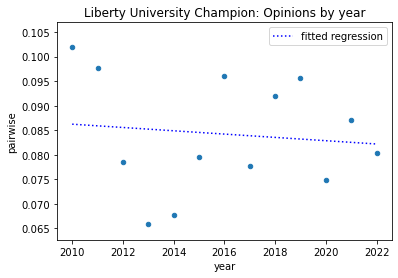

In [26]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Liberty University Champion: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mentions-norm slope:0.01116, int:0.07875, r:0.44220, p:0.13028, se:0.00682, x:range(0, 13)
pairwise slope:-0.00034, int:0.08623, r:-0.11235, p:0.71479, se:0.00090, x:range(0, 13)


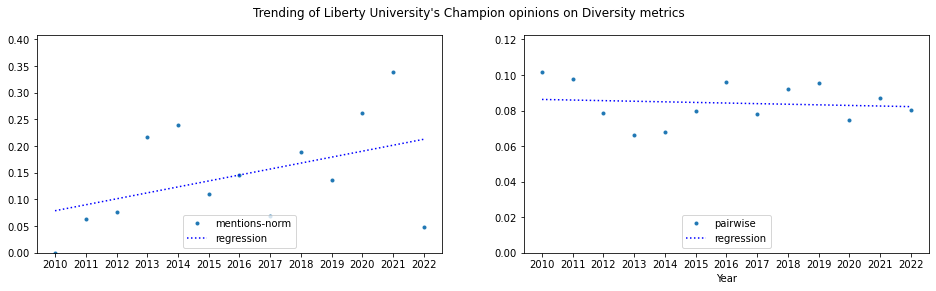

In [28]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

    # Add a title
    # ax.set_title(f"Trending of {column} in Liberty University's Champion")
    
plt.xlabel("Year")
plt.suptitle("Trending of Liberty University's Champion opinions on Diversity metrics")
plt.show()